In [1]:
import h3
import rasterio 
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pydeck as pdk
from rasterio.plot import show

In [69]:
def raster_to_df(raster_file):
    with rasterio.open(raster_file) as src:
        band1 = src.read(1)
        # bbox = src.bounds
        print(src.meta)
        cols, rows = np.meshgrid(np.arange(band1.shape[1]), np.arange(band1.shape[0])) #band1.shape[0]= height ; band1.shape[1] = width
        xs, ys = rasterio.transform.xy(src.transform, rows, cols)
        lons= np.array(xs)
        lats = np.array(ys)
    # Flatten the arrays and create a DataFrame
    df = pd.DataFrame({
        'Latitude': lats.flatten(),
        'Longitude': lons.flatten(),
        'Value': band1.flatten()})
    # Filter out no-data values
    df = df[df['Value'] != src.nodatavals[0]]

    return band1, df

In [112]:
raster_file = '/Users/wenyuc/Desktop/UT/data/raster/d_to_road_4326.tif'
band1, df = raster_to_df(raster_file)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 766, 'height': 671, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00014930167754569217, 0.0, 6.688594986,
       0.0, -8.816870342771737e-05, 52.341573125)}


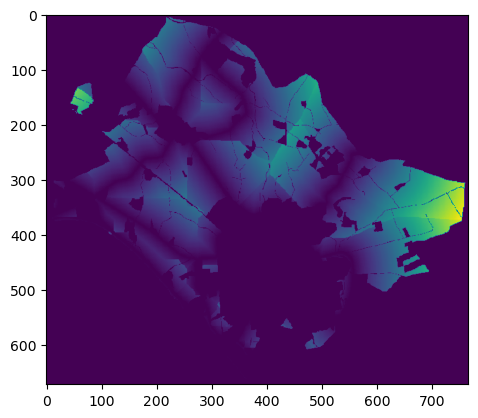

<Axes: >

In [113]:
show(band1)

In [114]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

In [115]:
# find hexs containing the points
df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.Latitude, x.Longitude, APERTURE_SIZE),1)

In [100]:
df.head()

,Latitude,Longitude,Value,hex9
4814,52.341,6.721217,1044.291504,891f161b58bffff
4819,52.341,6.721964,1024.281128,891f161b58bffff
4820,52.341,6.722113,1019.462341,891f161b58bffff
4821,52.341,6.722263,1014.719299,891f161b58bffff
4822,52.341,6.722412,1010.052917,891f161b58bffff


In [116]:
hex = df.groupby(hex_col)['Value'].mean().to_frame('Value').reset_index()

In [118]:
hex.to_csv('./hex/d_to_road_hex.csv')

In [117]:
# Define a layer to display on a map
layer = pdk.Layer(
    "H3HexagonLayer",
    hex,
    pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    opacity=0.7,
    get_hexagon="hex9",
    get_fill_color ='[255, 255, 255]', 
    get_line_color=[255, 255, 255],
    line_width_min_pixels=2)

# Set the viewport location
# view_state = pdk.ViewState(latitude=37.7749295, longitude=-122.4194155, zoom=14, bearing=0, pitch=30)
view_state = pdk.ViewState(longitude=6.747489560596507, latitude=52.316862707395394, zoom=10, bearing=0, pitch=0)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "Count: {Value}"})
r.to_html("h3_hexagon_layer.html")

In [104]:
def cell_to_shapely(cell):
    coords = h3.h3_to_geo_boundary(cell)
    flipped = tuple(coord[::-1] for coord in coords)
    return Polygon(flipped)

In [105]:
hex_geoms = hex['hex9'].apply(lambda x: cell_to_shapely(x))
h3_gdf = gpd.GeoDataFrame(data=hex, geometry=hex_geoms, crs=4326)
h3_gdf.head()

,hex9,Value,geometry
0,891f1618003ffff,2381.485596,"POLYGON ((6.79881 52.31260, 6.79909 52.31099, ..."
1,891f161800bffff,2337.385742,"POLYGON ((6.79681 52.30990, 6.79709 52.30830, ..."
2,891f1618013ffff,2218.873291,"POLYGON ((6.79597 52.31471, 6.79625 52.31311, ..."
3,891f1618017ffff,2436.876953,"POLYGON ((6.80081 52.31529, 6.80109 52.31369, ..."
4,891f161801bffff,2114.270996,"POLYGON ((6.79397 52.31202, 6.79425 52.31042, ..."


<Axes: >

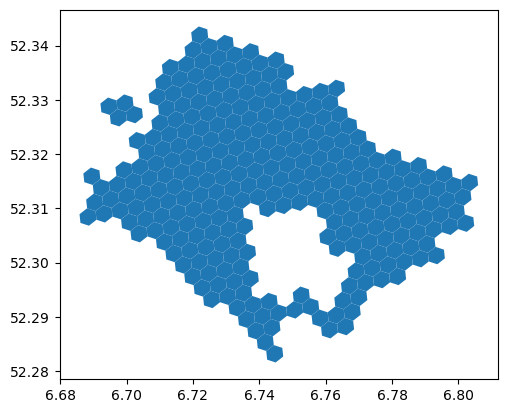

In [106]:
h3_gdf.plot()

In [107]:
with rasterio.open(r'./raster/d_to_road.tif') as src:
    band1 = src.read(1)

In [108]:
band1[np.isinf(band1)] = 0

In [109]:
# Open the original raster file
with rasterio.open(r'./raster/d_to_road.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open('/Users/wenyuc/Desktop/UT/data/raster/d_to_road_non_inf.tif', 'w', **profile) as dst:
        dst.write(band1, 1)

In [119]:
farm_hex = pd.read_csv('./hex/d_to_farm_hex.csv')
road_hex = pd.read_csv('./hex/d_to_road_hex.csv')

In [122]:
farm_hex

,Unnamed: 0,hex9,Value
0,0,891f1618003ffff,2381.4856
1,1,891f161800bffff,2337.3857
2,2,891f1618013ffff,2218.8733
3,3,891f1618017ffff,2436.8770
4,4,891f161801bffff,2114.2710
...,...,...,...
280,280,891f161b627ffff,2913.5730
281,281,891f161b62bffff,3391.3794
282,282,891f161b62fffff,3089.9436
283,283,891f161b633ffff,3285.7136


In [121]:
road_hex

,Unnamed: 0,hex9,Value
0,0,891f1618003ffff,2039.772100
1,1,891f161800bffff,2065.342000
2,2,891f1618013ffff,1821.108000
3,3,891f1618017ffff,2021.018800
4,4,891f161801bffff,1820.216600
...,...,...,...
280,280,891f161b627ffff,90.034520
281,281,891f161b62bffff,35.175900
282,282,891f161b62fffff,24.896670
283,283,891f161b633ffff,142.916430


In [148]:
fake_hex = road_hex.copy()
fake_hex['Value'] = np.random.randint(100,1001, 285)

In [150]:
fake_hex.to_csv('./hex/fake_hex.csv')

### Fuzzify the variables

In [126]:
# Transform distance to farm and road into numpy array
d_to_farm = np.array(farm_hex['Value'])
d_to_road = np.array(road_hex['Value'])

In [127]:
fuzzy_farm = np.maximum(0, 1 - (d_to_farm - d_to_farm.min()) / (d_to_farm.max() - d_to_farm.min()))
fuzzy_road = np.maximum(0, 1 - (d_to_road - d_to_road.min()) / (d_to_road.max() - d_to_road.min()))

In [ ]:
def fuzzify(df):
    df_array = np.array(df['Value'])
    fuzzified_array = np.maximum(0, 1 - (df_array - df_array.min()) / (df_array.max() - df_array.min()))
    return fuzzified_array

In [ ]:
def fuzzy_analysis_hex(*args, hex_df):
    # Fuzzy operation AND
    fuzzy = np.minimum(args)
    # # Find the indices of non-inf values in original raster layer
    # non_inf_indices = np.where(np.isfinite(og_raster))
    hex_df['fuzzy'] = fuzzy
    return hex_df

In [131]:
fuzzy = np.minimum(fuzzy_farm, fuzzy_road)

In [134]:
fuzzy_hex = farm_hex.copy()

In [135]:
fuzzy_hex

,Unnamed: 0,hex9,Value
0,0,891f1618003ffff,2381.4856
1,1,891f161800bffff,2337.3857
2,2,891f1618013ffff,2218.8733
3,3,891f1618017ffff,2436.8770
4,4,891f161801bffff,2114.2710
...,...,...,...
280,280,891f161b627ffff,2913.5730
281,281,891f161b62bffff,3391.3794
282,282,891f161b62fffff,3089.9436
283,283,891f161b633ffff,3285.7136


In [137]:
fuzzy_hex['fuzzy'] = fuzzy
fuzzy_hex = fuzzy_hex.drop(['Unnamed: 0', 'Value'], axis=1)

In [138]:
fuzzy_hex

,hex9,fuzzy
0,891f1618003ffff,0.043984
1,891f161800bffff,0.031908
2,891f1618013ffff,0.147255
3,891f1618017ffff,0.052841
4,891f161801bffff,0.147676
...,...,...
280,891f161b627ffff,0.164346
281,891f161b62bffff,0.022344
282,891f161b62fffff,0.111929
283,891f161b633ffff,0.053747


Text(0, 0.5, 'Frequency')

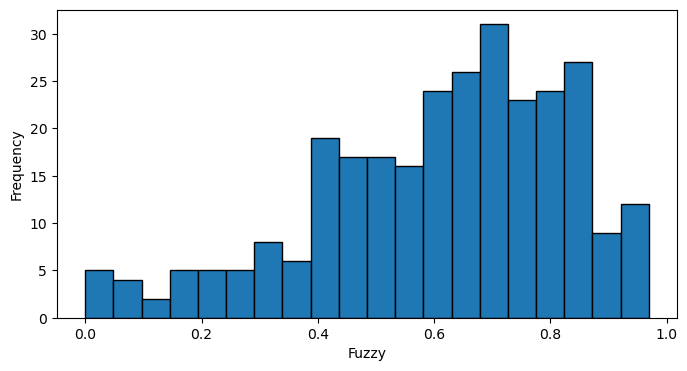

In [146]:
# Create subplots
plt.figure(figsize=(8, 4))
plt.hist(fuzzy, bins=20, edgecolor='black')
plt.xlabel('Fuzzy')
plt.ylabel('Frequency')

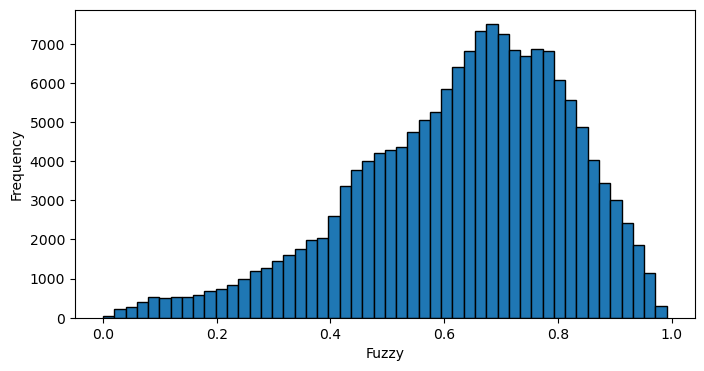

In [147]:
with rasterio.open("./raster/fuzzy_and_1.tif") as src:
    band1 = src.read(1)
    # Create subplots
    plt.figure(figsize=(8, 4))
    plt.hist(band1[np.isfinite(band1)], bins=50, edgecolor='black')
    plt.xlabel('Fuzzy')
    plt.ylabel('Frequency')

In [130]:
def fuzzy_analysis(*args, og_raster, og_raster_path, new_raster_path):
    """
    This is the fuzzy analysis function to perform on raster layer. 
    args: arrays of fuzzified criteria 
    """
    # Fuzzy operation AND
    fuzzy = np.minimum(args)
    # Find the indices of non-inf values in original raster layer
    non_inf_indices = np.where(np.isfinite(og_raster))
    
    if len(fuzzy) == len(non_inf_indices[0]):
        # Replace the non-inf values in original raster layer with fuzzy values
        m = np.copy(og_raster)
        m[non_inf_indices] = fuzzy
    else:
        print("Can not proceed")
    
    # Save the fuzzy array 
    with rasterio.open(og_raster_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.float32, count=1)
        with rasterio.open(new_raster_path, 'w', **profile) as dst:
            dst.write(m, 1)
    return fuzzy

In [2]:
farm_hex = pd.read_csv('./hex/d_to_farm_hex.csv')
road_hex = pd.read_csv('./hex/d_to_road_hex.csv')
fake_hex = pd.read_csv('./hex/fake_hex.csv')

In [3]:
def fuzzify(df):
    df_array = np.array(df['Value'])
    fuzzified_array = np.maximum(0, 1 - (df_array - df_array.min()) / (df_array.max() - df_array.min()))
    return fuzzified_array

def fuzzy_analysis_hex(*args):
    # Fuzzy operation AND
    fuzzy = np.minimum(args)
    return fuzzy 

In [5]:
fuzzy_farm = fuzzify(farm_hex)
fuzzy_road = fuzzify(road_hex)
fuzzy_fake = fuzzify(fake_hex)

In [6]:
all_arrays = {'Farm': fuzzy_farm, 'Road': fuzzy_road, 'Fake': fuzzy_fake}

In [13]:
# Create multiple arrays
array1 = np.array([1, 5, 3, 8])
array2 = np.array([2, 4, 1, 7])
array3 = np.array([0, 6, 2, 9])

# Store arrays in a list
array_list = [array1, array2, array3]

In [18]:
data_dict = {'Farm': array1,
             'City':array2,
             'Village': array3}

In [20]:
# Your list of keys
keys_to_extract = ['Farm', 'City']

In [21]:
# Extract arrays using a list comprehension
arrays_to_extract = [data_dict[key] for key in keys_to_extract]

# Now arrays_to_extract contains the arrays corresponding to the keys in the list
for key, arr in zip(keys_to_extract, arrays_to_extract):
    print(f"{key}: {arr}")

Farm: [1 5 3 8]
City: [2 4 1 7]


In [23]:
# Use a loop to compute the element-wise minimum
result_array = array_list[0]  # Initialize with the first array

In [26]:
for arr in array_list[1:]:
    result_array = np.minimum(result_array, arr)

print("Original Arrays:")
for i, arr in enumerate(array_list, start=1):
    print(f"Array {i}:", arr)

print("\nElement-wise Minimum:")
print("Result Array:", result_array)

Original Arrays:
Array 1: [1 5 3 8]
Array 2: [2 4 1 7]
Array 3: [0 6 2 9]

Element-wise Minimum:
Result Array: [0 4 1 7]


In [27]:
def fuzzify(df):
    df_array = np.array(df['Value'])
    fuzzified_array = np.maximum(0, 1 - (df_array - df_array.min()) / (df_array.max() - df_array.min()))
    return fuzzified_array

In [29]:
fuzzy_farm = fuzzify(farm_hex)

In [31]:
fuzzy_farm.shape

(285,)

In [32]:
farm_hex

,Unnamed: 0,hex9,Value
0,0,891f1618003ffff,2381.4856
1,1,891f161800bffff,2337.3857
2,2,891f1618013ffff,2218.8733
3,3,891f1618017ffff,2436.8770
4,4,891f161801bffff,2114.2710
...,...,...,...
280,280,891f161b627ffff,2913.5730
281,281,891f161b62bffff,3391.3794
282,282,891f161b62fffff,3089.9436
283,283,891f161b633ffff,3285.7136


In [33]:
df = farm_hex[['hex9']]
df

,hex9
0,891f1618003ffff
1,891f161800bffff
2,891f1618013ffff
3,891f1618017ffff
4,891f161801bffff
...,...
280,891f161b627ffff
281,891f161b62bffff
282,891f161b62fffff
283,891f161b633ffff
